**NEW**

**Cell 1: Imports & Paths & Quick checks**


In [1]:
# --- Cell 1: imports & paths (σταθερά) ---
from pathlib import Path
import json
import numpy as np
import scipy.sparse as sp
import lightgbm as lgb

# δεν θα κάνουμε ακόμα training εδώ, απλώς ορίζουμε paths
BASE = Path.home() / "Desktop" / "Malware Project"
VEC  = BASE / "data" / "behavior_vectors_paper"

LABEL_MAP = VEC / "label_map.json"
XTRN = sorted(VEC.glob("train_part*.npz"))
YTRN = sorted(VEC.glob("y_train_part*.npy"))
XTE  = sorted(VEC.glob("test_part*.npz"))
YTE  = sorted(VEC.glob("y_test_part*.npy"))

print("BASE:", BASE)
print("VEC :", VEC)
print("parts: train =", len(XTRN), "|", len(YTRN), " — test =", len(XTE), "|", len(YTE))

# sanity checks
assert LABEL_MAP.exists(), "Λείπει το label_map.json"
assert len(XTRN) == len(YTRN) > 0, "Train X/Y parts δεν ταιριάζουν"
assert len(XTE)  == len(YTE)  > 0, "Test  X/Y parts δεν ταιριάζουν"


BASE: /Users/georgektenas/Desktop/Malware Project
VEC : /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper
parts: train = 551 | 551  — test = 45 | 45


**Cell 2: Load labels & helpers to read parts**


In [65]:
# --- Cell 2: load labels & helpers ---
# labels (σειρά = στήλες των Y)
with open(LABEL_MAP, "r") as f:
    label_names = json.load(f)["labels"]
n_labels   = len(label_names)
tag_to_idx = {t: i for i, t in enumerate(label_names)}

print("n_labels:", n_labels)
print("sample labels:", label_names[:10])

# --- REPLACE part_paths with this version ---
def part_paths(i: int, split: str = "train"):
    """Επιστρέφει τα πραγματικά paths από τις λίστες (XTRN/XTE & YTRN/YTE)."""
    if split not in ("train", "test"):
        raise ValueError("split must be 'train' or 'test'")
    parts = XTRN if split == "train" else XTE
    yparts = YTRN if split == "train" else YTE
    return parts[i], yparts[i]

    return xp, yp

def load_part(i: int, split: str = "train"):
    """Φορτώνει 1 part στη μνήμη: X (csr), Y (np.ndarray int8)"""
    xp, yp = part_paths(i, split)
    X = sp.load_npz(xp)            # απο sp.save_npz(...)
    Y = np.load(yp, allow_pickle=False)  # shape: (rows, n_labels), dtype=int8
    return X, Y

def iter_parts(split: str = "train"):
    """Generator πάνω από όλα τα parts με σωστή σειρά."""
    parts = XTRN if split == "train" else XTE
    for i in range(len(parts)):
        yield i, load_part(i, split)


n_labels: 75
sample labels: ['adware', 'antiav', 'antifw', 'autorun', 'backdoor', 'banker', 'bho', 'binder', 'blocker', 'bootkit']


**Cell 3: Config, paths & helpers for counts/weights**


In [66]:
# --- Cell 3: training config & helpers ---

from pathlib import Path
import json, gc, time
import numpy as np
import lightgbm as lgb
import scipy.sparse as sp

# Χρησιμοποιούμε τα ήδη φορτωμένα αντικείμενα από τα προηγούμενα κελιά:
# BASE, VEC, XTRN, YTRN, XTE, YTE, label_names, n_labels, tag_to_idx

MODELS_DIR = (VEC / "models")
MODELS_DIR.mkdir(exist_ok=True)

# 1️⃣ Boosting rounds per pass
ROUNDS_PER_PASS = 50     # κάθε pass κάνει 50 γύρους
MAX_PASSES       = 2     # δύο περάσματα -> συνολικά ~100 rounds όπως στο paper

# 2️⃣ LightGBM παραμέτροι για γρήγορο, σταθερό training
def lgb_params_for_label(pos, neg):
    spw = float(neg / max(1, pos))  # scale_pos_weight για imbalance
    return {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": 0.1,
        "num_leaves": 31,
        "max_bin": 63,
        "feature_fraction": 0.7,
        "bagging_fraction": 0.7,
        "bagging_freq": 1,
        "min_data_in_leaf": 50,
        "min_sum_hessian_in_leaf": 1e-3,
        "verbose": -1,
        "scale_pos_weight": spw,
        "num_threads": 0,   # 0 => auto, αφήνει το LightGBM να επιλέξει CPU cores
    }

# 3️⃣ Υπολογισμός θετικών/αρνητικών για κάθε label (streaming, χωρίς φόρτωση όλων)
def compute_label_counts(split="train"):
    parts = XTRN if split == "train" else XTE
    pos = np.zeros(n_labels, dtype=np.int64)
    neg = np.zeros(n_labels, dtype=np.int64)
    
    for i in range(len(parts)):
        _, y = load_part(i, split)
        p = y.sum(axis=0).astype(np.int64)
        n = y.shape[0] - p
        pos += p
        neg += n
        del y
        gc.collect()
    
    return pos, neg

print("🔢 Counting positives/negatives per label…")
pos_cnt, neg_cnt = compute_label_counts("train")
print("✅ Done. Example counts for first 10 labels:")
for name, p, n in zip(label_names[:10], pos_cnt[:10], neg_cnt[:10]):
    print(f"{name:<15} pos={p:<8} neg={n}")


🔢 Counting positives/negatives per label…
✅ Done. Example counts for first 10 labels:
adware          pos=487481   neg=2266808
antiav          pos=76890    neg=2677399
antifw          pos=103914   neg=2650375
autorun         pos=108109   neg=2646180
backdoor        pos=201156   neg=2553133
banker          pos=101629   neg=2652660
bho             pos=99830    neg=2654459
binder          pos=5304     neg=2748985
blocker         pos=8160     neg=2746129
bootkit         pos=12       neg=2754277


In [67]:
# --- Cell 3B: Select kept labels (drop rare) & save mapping ---

import json
import numpy as np
from pathlib import Path

MIN_POS = 500  # όπως στο paper για Behavior

# Χρησιμοποιούμε τα counts από πριν
# pos_cnt, neg_cnt = compute_label_counts("train")  # αν δεν υπάρχουν στη μνήμη, ξανακάλεσέ το

kept_idx = np.where(pos_cnt >= MIN_POS)[0]
dropped_idx = np.where(pos_cnt < MIN_POS)[0]

print(f"Σύνολο labels: {n_labels}")
print(f"Κρατάμε: {len(kept_idx)} | Πετάμε (pos<{MIN_POS}): {len(dropped_idx)}")

# Φόρτωσε τα label_names από το LABEL_MAP που ήδη έχεις
with open(LABEL_MAP, "r") as f:
    _lm = json.load(f)
label_names_full = _lm["labels"]

kept_names = [label_names_full[i] for i in kept_idx.tolist()]
dropped_names = [label_names_full[i] for i in dropped_idx.tolist()]

print("Δείγμα kept:", kept_names[:10])
print("Δείγμα dropped:", dropped_names[:10])

# Αποθήκευση kept indices για μελλοντική χρήση
KEPT_IDX_PATH = VEC / "kept_label_indices.npy"
np.save(KEPT_IDX_PATH, kept_idx)
print("Saved:", KEPT_IDX_PATH)

# Δημιούργησε νέο label_map (balanced)
BAL_LABEL_MAP = VEC / "label_map_balanced.json"
with open(BAL_LABEL_MAP, "w") as f:
    json.dump({"labels": kept_names}, f, indent=2)
print("Saved:", BAL_LABEL_MAP)


Σύνολο labels: 75
Κρατάμε: 64 | Πετάμε (pos<500): 11
Δείγμα kept: ['adware', 'antiav', 'antifw', 'autorun', 'backdoor', 'banker', 'bho', 'binder', 'blocker', 'bundler']
Δείγμα dropped: ['bootkit', 'cdeject', 'exploitkit', 'fakejquery', 'hidelink', 'iframe', 'phishing', 'redirector', 'refresh', 'scrinject']
Saved: /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/kept_label_indices.npy
Saved: /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/label_map_balanced.json


In [64]:
# --- Cell 3C: Create balanced Y parts (filter label columns to kept) ---

import numpy as np
from pathlib import Path

kept_idx = np.load(KEPT_IDX_PATH)
kept_idx = kept_idx.astype(np.int64)

def save_filtered_y_parts(split="train"):
    parts = XTRN if split=="train" else XTE
    yparts = YTRN if split=="train" else YTE

    out_names = []
    for i in range(len(parts)):
        yp = np.load(yparts[i], allow_pickle=False)  # shape: (rows, n_labels), int8
        yp_bal = yp[:, kept_idx]                     # κρατάμε μόνο τις kept στήλες
        outp = yparts[i].with_name(yparts[i].stem.replace("_part", "_part_balanced") + yparts[i].suffix)
        np.save(outp, yp_bal.astype(np.int8), allow_pickle=False)
        out_names.append(outp)
        print(f"[{split}] saved:", outp, "shape:", yp_bal.shape)
    return out_names

train_bal_paths = save_filtered_y_parts("train")
test_bal_paths  = save_filtered_y_parts("test")


[train] saved: /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/y_train_part_balanced000.npy shape: (5000, 64)
[train] saved: /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/y_train_part_balanced001.npy shape: (5000, 64)
[train] saved: /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/y_train_part_balanced002.npy shape: (5000, 64)
[train] saved: /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/y_train_part_balanced003.npy shape: (5000, 64)
[train] saved: /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/y_train_part_balanced004.npy shape: (5000, 64)
[train] saved: /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/y_train_part_balanced005.npy shape: (5000, 64)
[train] saved: /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/y_train_part_balanced006.npy shape: (5000, 64)
[train] saved: /Users/georgektenas/Desktop/Malware Project/dat

In [69]:
# --- Cell 3D: compute caps & keep probs per label (MalDICT-style) ---

import numpy as np

# Φόρτωσε kept indices (64) για σιγουριά
kept_idx = np.load(KEPT_IDX_PATH).astype(np.int64)

def count_pos_over_parts(split="train"):
    parts = XTRN if split=="train" else XTE
    yparts = [p.with_name(p.stem.replace("_part", "_part_balanced") + p.suffix).with_suffix(".npy")
              for p in (YTRN if split=="train" else YTE)]
    pos = np.zeros(len(kept_idx), dtype=np.int64)
    n_rows = 0
    for yp in yparts:
        y = np.load(yp, allow_pickle=False)   # shape: (rows, K)
        pos += y.sum(axis=0).astype(np.int64)
        n_rows += y.shape[0]
    return pos, n_rows

# μετρήσεις
pos_train, n_train = count_pos_over_parts("train")
pos_test,  n_test  = count_pos_over_parts("test")

min_pos_train = int(pos_train.min()) if (pos_train>0).any() else 0
min_pos_test  = int(pos_test.min())  if (pos_test>0).any()  else 0

cap_train = 100 * max(1, min_pos_train)   # όπως στο paper
cap_test  = 25  * max(1, min_pos_test)    # όπως στο paper

print(f"Train positives per kept label (min={min_pos_train})  -> cap_train={cap_train}")
print(f"Test  positives per kept label (min={min_pos_test})   -> cap_test ={cap_test}")

# keep probability ανά label (<=1), ώστε να μη ξεπερνάμε το cap σε προσδοκία
keep_prob_train = np.minimum(1.0, cap_train / np.maximum(1, pos_train)).astype(float)
keep_prob_test  = np.minimum(1.0, cap_test  / np.maximum(1, pos_test )).astype(float)

print("Παράδειγμα keep_prob_train (πρώτα 10):", keep_prob_train[:10])



Train positives per kept label (min=725)  -> cap_train=72500
Test  positives per kept label (min=0)   -> cap_test =25
Παράδειγμα keep_prob_train (πρώτα 10): [0.14872375 0.94290545 0.69769232 0.67061947 0.36041679 0.71337906
 0.7262346  1.         1.         1.        ]


In [70]:
# --- Cell 3E: apply downsampling per label and save new capped parts ---

import numpy as np
import scipy.sparse as sp
from pathlib import Path
import random

rng = np.random.default_rng(12345)  # σταθεροποιεί το sampling

def capped_paths(xp: Path, yp_bal: Path):
    """Φτιάχνει νέα ονόματα για capped αρχεία με ίδιο suffix."""
    x_out = xp.with_name(xp.stem.replace("_part", "_part_capped") + xp.suffix)
    y_out = yp_bal.with_name(yp_bal.stem.replace("_part_balanced", "_part_capped") + yp_bal.suffix)
    return x_out, y_out

def downsample_and_save(split="train"):
    parts = XTRN if split=="train" else XTE
    yparts_bal = [p.with_name(p.stem.replace("_part", "_part_balanced") + p.suffix).with_suffix(".npy")
                  for p in (YTRN if split=="train" else YTE)]
    keep_prob = keep_prob_train if split=="train" else keep_prob_test

    total_in, total_kept = 0, 0
    kept_pos = np.zeros_like(keep_prob, dtype=np.int64)  # μετρητής θετικών που κρατήθηκαν (διαγνωστικός)

    for i in range(len(parts)):
        xp = parts[i]
        yp = yparts_bal[i]

        # load
        X = sp.load_npz(xp)               # csr
        Y = np.load(yp, allow_pickle=False)  # (rows, K), int8
        rows = Y.shape[0]
        total_in += rows

        # per-row keep prob = min keep_prob των θετικών labels σε αυτή τη γραμμή (ή 1.0 αν δεν έχει θετικά)
        # (ώστε να τηρούμε caps για όλα τα labels που εμφανίζονται στη γραμμή)
        # Y is int8 {0/1}; βρίσκουμε indices των θετικών ανά row
        # για τα αραιά "0/1", αυτός ο υπολογισμός είναι ΟΚ σε ταχύτητα για μέγεθος part ~ 5k
        row_keep = np.ones(rows, dtype=float)
        pos_cols = Y.nonzero()  # (row_idx, col_idx) όπου y=1
        # αρχικοποίηση με 1.0 και κατόπιν παίρνουμε το ελάχιστο ανά row
        # φτιάχνουμε προσωρινό vector ίδιου μήκους με pos_cols[0]
        row_min = np.ones(rows, dtype=float)
        # περάσματα για να πάρουμε min per row
        for r, c in zip(*pos_cols):
            if keep_prob[c] < row_min[r]:
                row_min[r] = keep_prob[c]
        # όπου δεν είχε θετικά (row_min=1.0), αφήνουμε 1.0
        row_keep = row_min

        # Bernoulli keep
        u = rng.random(rows)
        mask = u < row_keep

        # ενημέρωση μετρητών θετικών που κρατήθηκαν (διαγνωστικό)
        if mask.any():
            kept_pos += Y[mask].sum(axis=0).astype(np.int64)

        # apply mask
        Xc = X[mask]
        Yc = Y[mask]

        # save
        x_out, y_out = capped_paths(xp, Path(yp))
        sp.save_npz(x_out, Xc)
        np.save(y_out, Yc.astype(np.int8), allow_pickle=False)

        total_kept += int(mask.sum())
        print(f"[{split}] {xp.name} -> kept {int(mask.sum())}/{rows} rows | saved: {x_out.name}, {y_out.name}")

    print(f"[{split}] TOTAL kept rows: {total_kept} / {total_in}")
    return kept_pos, total_kept, total_in

kept_pos_train, kept_rows_train, total_rows_train = downsample_and_save("train")
kept_pos_test,  kept_rows_test,  total_rows_test  = downsample_and_save("test")

print("Δείγμα kept_pos_train (πρώτα 10):", kept_pos_train[:10])


[train] train_part000.npz -> kept 2851/5000 rows | saved: train_part_capped000.npz, y_train_part_capped000.npy
[train] train_part001.npz -> kept 2810/5000 rows | saved: train_part_capped001.npz, y_train_part_capped001.npy
[train] train_part002.npz -> kept 2803/5000 rows | saved: train_part_capped002.npz, y_train_part_capped002.npy
[train] train_part003.npz -> kept 2521/5000 rows | saved: train_part_capped003.npz, y_train_part_capped003.npy
[train] train_part004.npz -> kept 2479/5000 rows | saved: train_part_capped004.npz, y_train_part_capped004.npy
[train] train_part005.npz -> kept 2560/5000 rows | saved: train_part_capped005.npz, y_train_part_capped005.npy
[train] train_part006.npz -> kept 2431/5000 rows | saved: train_part_capped006.npz, y_train_part_capped006.npy
[train] train_part007.npz -> kept 2350/5000 rows | saved: train_part_capped007.npz, y_train_part_capped007.npy
[train] train_part008.npz -> kept 2374/5000 rows | saved: train_part_capped008.npz, y_train_part_capped008.npy
[

In [74]:
# --- VARIANT helpers (βάλε το ΑΚΡΙΒΩΣ πριν από το Cell 4) ---

from pathlib import Path
import numpy as np
import scipy.sparse as sp

# Διάλεξε τι τρέχεις τώρα:
VARIANT = "capped"   # "raw" | "balanced" | "capped"

def _variant_paths(x_path: Path, y_path: Path, variant: str):
    """Δίνεις τα raw paths από XTRN/XTE & YTRN/YTE και επιστρέφει paths για το επιλεγμένο variant."""
    if variant == "raw":
        Xp = x_path
        Yp = y_path
    elif variant == "balanced":
        Xp = x_path  # balanced δεν αλλάξαμε X
        Yp = y_path.with_name(y_path.stem.replace("_part", "_part_balanced") + y_path.suffix).with_suffix(".npy")
    elif variant == "capped":
        Xp = x_path.with_name(x_path.stem.replace("_part", "_part_capped") + x_path.suffix)
        Yp = y_path.with_name(y_path.stem.replace("_part", "_part_capped") + y_path.suffix).with_suffix(".npy")
    else:
        raise ValueError("VARIANT must be 'raw', 'balanced', or 'capped'")
    return Xp, Yp

def part_paths(i: int, split: str = "train", variant: str | None = None):
    """Επιστρέφει τα paths για το split & variant, χρησιμοποιώντας τις λίστες XTRN/XTE και YTRN/YTE."""
    if variant is None:
        variant = VARIANT
    if split not in ("train","test"):
        raise ValueError("split must be 'train' or 'test'")
    x_list = XTRN if split=="train" else XTE
    y_list = YTRN if split=="train" else YTE
    return _variant_paths(x_list[i], y_list[i], variant)

def load_part(i: int, split: str = "train", variant: str | None = None):
    """Φορτώνει 1 part (X csr, Y int8) για το επιλεγμένο variant."""
    Xp, Yp = part_paths(i, split=split, variant=variant)
    X = sp.load_npz(Xp)
    Y = np.load(Yp, allow_pickle=False).astype(np.int8)
    return X, Y

# Μικρός έλεγχος:
for i in range(min(3, len(XTRN))):
    Xp, Yp = part_paths(i, "train")
    print("train:", Xp.name, "|", Yp.name)
for i in range(min(2, len(XTE))):
    Xp, Yp = part_paths(i, "test")
    print("test :", Xp.name, "|", Yp.name)


train: train_part_capped000.npz | y_train_part_capped000.npy
train: train_part_capped001.npz | y_train_part_capped001.npy
train: train_part_capped002.npz | y_train_part_capped002.npy
test : test_part_capped000.npz | y_test_part_capped000.npy
test : test_part_capped001.npz | y_test_part_capped001.npy


**Cell 4: OVR training loop (streaming, init_model)**


In [12]:
# --- Cell 4: OVR training (streaming with init_model) ---

import time, gc
from pathlib import Path
import numpy as np
import lightgbm as lgb

# Χρησιμοποιεί τις μεταβλητές από τα προηγούμενα κελιά:
# - n_labels, label_names, XTRN, YTRN, load_part
# - ROUNDS_PER_PASS, MAX_PASSES, pos_cnt, neg_cnt, lgb_params_for_label, MODELS_DIR

def model_path_for(label_idx: int) -> Path:
    return MODELS_DIR / f"lgb_label_{label_idx:03d}.txt"

def train_one_label(label_idx: int):
    """OVR training για ένα label, σε passes & parts, με init_model."""
    name = label_names[label_idx]
    mpath = model_path_for(label_idx)
    booster = None

    # Παράμετροι βασισμένοι στο imbalance του συγκεκριμένου label
    params = lgb_params_for_label(pos_cnt[label_idx], neg_cnt[label_idx])

    t0 = time.time()
    print(f"\n🚀 Training label [{label_idx}/{n_labels-1}] '{name}' "
          f"(pos={pos_cnt[label_idx]}, neg={neg_cnt[label_idx]})")

    for p in range(MAX_PASSES):
        pass_t0 = time.time()
        print(f"  • Pass {p+1}/{MAX_PASSES}")

        for i in range(len(XTRN)):
            X, Y = load_part(i, split="train")
            y = Y[:, label_idx].astype(np.float32)

            # Dataset από το τρέχον part
            dtrain = lgb.Dataset(X, label=y, free_raw_data=True)

            # Συνεχίζουμε το ίδιο booster με επιπλέον γύρους (init_model=booster)
            booster = lgb.train(
                params,
                dtrain,
                num_boost_round=ROUNDS_PER_PASS,
                init_model=booster,
                callbacks=[lgb.log_evaluation(period=25)],
            
            )


            # καθάρισμα μνήμης
            del X, Y, y, dtrain
            gc.collect()

        dt = time.time() - pass_t0
        print(f"    ✓ Pass {p+1} done in {dt/60:.1f} min")

    # Αποθήκευση μοντέλου
    booster.save_model(str(mpath))
    total_dt = time.time() - t0
    print(f"✅ Saved model: {mpath.name} | total {total_dt/60:.1f} min")

    # Επιστρέφουμε λίγη χρήσιμη πληροφορία
    return {
        "label_idx": label_idx,
        "label_name": name,
        "rounds_total": ROUNDS_PER_PASS * MAX_PASSES,
        "model_path": str(mpath),
        "train_minutes": total_dt / 60.0,
    }

def train_many(labels):
    """Βολικό wrapper για να τρέξεις πολλά labels σειριακά."""
    infos = []
    for li in labels:
        info = train_one_label(li)
        infos.append(info)
    return infos

# 💡 Πρόβα με λίγα labels πρώτα για να δεις ροή/χρόνους:
#   - π.χ. 3 labels: τα 2 πρώτα + ένα της επιλογής σου (πχ 'worm' αν υπάρχει)
#   - βρες index με: label_names.index('worm')  (αν υπάρχει στο label_map)
try:
    worm_idx = label_names.index('worm')
except ValueError:
    worm_idx = None

demo_labels = [0, 1] + ([worm_idx] if worm_idx is not None else [])
demo_labels = [li for li in demo_labels if li is not None]

print("🧪 Demo training labels:", [f"{li}:{label_names[li]}" for li in demo_labels])
demo_info = train_many(demo_labels)

full_info = train_many(range(n_labels))


🧪 Demo training labels: ['0:adware', '1:antiav', '74:worm']

🚀 Training label [0/74] 'adware' (pos=487481, neg=2266808)
  • Pass 1/2
    ✓ Pass 1 done in 3.5 min
  • Pass 2/2
    ✓ Pass 2 done in 3.3 min
✅ Saved model: lgb_label_000.txt | total 6.7 min

🚀 Training label [1/74] 'antiav' (pos=76890, neg=2677399)
  • Pass 1/2
    ✓ Pass 1 done in 3.0 min
  • Pass 2/2
    ✓ Pass 2 done in 3.0 min
✅ Saved model: lgb_label_001.txt | total 6.0 min

🚀 Training label [74/74] 'worm' (pos=468876, neg=2285413)
  • Pass 1/2
    ✓ Pass 1 done in 3.6 min
  • Pass 2/2
    ✓ Pass 2 done in 3.6 min
✅ Saved model: lgb_label_074.txt | total 7.2 min

🚀 Training label [0/74] 'adware' (pos=487481, neg=2266808)
  • Pass 1/2
    ✓ Pass 1 done in 3.3 min
  • Pass 2/2
    ✓ Pass 2 done in 3.3 min
✅ Saved model: lgb_label_000.txt | total 6.6 min

🚀 Training label [1/74] 'antiav' (pos=76890, neg=2677399)
  • Pass 1/2
    ✓ Pass 1 done in 3.0 min
  • Pass 2/2
    ✓ Pass 2 done in 3.0 min
✅ Saved model: lgb_label_00

**Cell 5: Paths, load paths & helpers (load booster, iterate test)**

In [14]:
# --- Cell 5A: paths & helpers για evaluation ---

from pathlib import Path
import json, numpy as np
import lightgbm as lgb
import scipy.sparse as sp

# ίδιος φάκελος με τα νέα vectors
BASE = Path.home() / "Desktop" / "Malware Project"
VEC  = BASE / "data" / "behavior_vectors_paper"
MODELS_DIR = VEC / "models"

LABEL_MAP = VEC / "label_map.json"
with open(LABEL_MAP, "r") as f:
    label_names = json.load(f)["labels"]
n_labels = len(label_names)

def part_paths(idx: int, split="test"):
    xp = VEC / f"{split}_part{idx:03d}.npz"
    yp = VEC / f"y_{split}_part{idx:03d}.npy"
    return xp, yp

# λίστα όλων των test parts
XTE = sorted(VEC.glob("test_part*.npz"))
YTE = sorted(VEC.glob("y_test_part*.npy"))

def load_part(i: int, split="test"):
    xp, yp = part_paths(i, split)
    X = sp.load_npz(xp)
    Y = np.load(yp, allow_pickle=False).astype(np.int8)
    return X, Y

def model_path_for(label_idx: int) -> Path:
    return MODELS_DIR / f"lgb_label_{label_idx:03d}.txt"

def load_booster(label_idx: int) -> lgb.Booster:
    return lgb.Booster(model_file=str(model_path_for(label_idx)))



**Cell 6: Per-label evaluation (stream) + save CSV**


In [15]:
# --- Cell 5B: per-label evaluation & CSV ---

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import pandas as pd
from time import time

def eval_one_label(li: int):
    """Επιστρέφει dict με metrics για 1 label, κάνοντας stream όλα τα test parts."""
    name = label_names[li]
    booster = load_booster(li)

    all_true = []
    all_proba = []

    for idx in range(len(XTE)):
        X, Y = load_part(idx, split="test")
        y_true = Y[:, li].astype(np.float32)
        y_proba = booster.predict(X)  # (rows,)
        all_true.append(y_true)
        all_proba.append(y_proba)

    y_true = np.concatenate(all_true)
    y_proba = np.concatenate(all_proba)
    y_pred = (y_proba >= 0.5).astype(np.int8)

    # βασικά metrics
    prev = float(y_true.mean())
    try:
        auc = float(roc_auc_score(y_true, y_proba))
    except ValueError:
        auc = float("nan")  # (αν το label είναι degenerate)

    p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    # μετράμε και counts
    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())

    return {
        "label_idx": li,
        "label": name,
        "prevalence": prev,
        "auc": auc,
        "precision": float(p_micro),
        "recall": float(r_micro),
        "f1": float(f1_micro),
        "tp": tp, "fp": fp, "fn": fn,
        "n": int(y_true.size),
    }

# τρέχουμε για όλα τα labels και σώζουμε CSV
t0 = time()
rows = []
for li in range(n_labels):
    print(f"[{li+1:02d}/{n_labels}] eval '{label_names[li]}' ...")
    rows.append(eval_one_label(li))
df = pd.DataFrame(rows)

per_label_csv = VEC / "per_label_metrics.csv"
df.to_csv(per_label_csv, index=False)
print(f"\nSaved per-label CSV → {per_label_csv}")
print(f"Done in {int(time()-t0)} sec")
df.head(10)


[01/75] eval 'adware' ...
[02/75] eval 'antiav' ...
[03/75] eval 'antifw' ...
[04/75] eval 'autorun' ...
[05/75] eval 'backdoor' ...
[06/75] eval 'banker' ...
[07/75] eval 'bho' ...
[08/75] eval 'binder' ...
[09/75] eval 'blocker' ...
[10/75] eval 'bootkit' ...


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[11/75] eval 'bundler' ...
[12/75] eval 'cdeject' ...


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[13/75] eval 'clicker' ...
[14/75] eval 'coinminer' ...
[15/75] eval 'constructor' ...
[16/75] eval 'cryptor' ...
[17/75] eval 'ddos' ...
[18/75] eval 'dialer' ...
[19/75] eval 'downloader' ...
[20/75] eval 'dropper' ...
[21/75] eval 'email' ...
[22/75] eval 'exploit' ...
[23/75] eval 'exploitkit' ...


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[24/75] eval 'fakealert' ...
[25/75] eval 'fakeantivirus' ...
[26/75] eval 'fakejquery' ...


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[27/75] eval 'flooder' ...
[28/75] eval 'fraud' ...
[29/75] eval 'ftp' ...


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[30/75] eval 'gamehack' ...
[31/75] eval 'gamethief' ...
[32/75] eval 'hacktool' ...
[33/75] eval 'hidelink' ...


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[34/75] eval 'hoax' ...
[35/75] eval 'hotbar' ...
[36/75] eval 'iframe' ...


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[37/75] eval 'injector' ...
[38/75] eval 'installer' ...
[39/75] eval 'ircbot' ...
[40/75] eval 'joke' ...
[41/75] eval 'keygen' ...
[42/75] eval 'keylogger' ...
[43/75] eval 'lockscreen' ...
[44/75] eval 'net' ...
[45/75] eval 'nettool' ...
[46/75] eval 'nuker' ...
[47/75] eval 'packed' ...
[48/75] eval 'passwordstealer' ...
[49/75] eval 'patcher' ...
[50/75] eval 'phishing' ...


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[51/75] eval 'porn' ...
[52/75] eval 'proxy' ...
[53/75] eval 'pua' ...
[54/75] eval 'rahack' ...
[55/75] eval 'ransom' ...
[56/75] eval 'rat' ...
[57/75] eval 'redirector' ...


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[58/75] eval 'refresh' ...


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[59/75] eval 'riskware' ...
[60/75] eval 'rootkit' ...
[61/75] eval 'screensaver' ...
[62/75] eval 'scrinject' ...


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[63/75] eval 'selfdel' ...
[64/75] eval 'servstart' ...
[65/75] eval 'sms' ...


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


[66/75] eval 'spam' ...
[67/75] eval 'spyware' ...
[68/75] eval 'startpage' ...
[69/75] eval 'stealer' ...
[70/75] eval 'toolbar' ...
[71/75] eval 'vbinject' ...
[72/75] eval 'virtool' ...
[73/75] eval 'virus' ...
[74/75] eval 'webtoolbar' ...
[75/75] eval 'worm' ...

Saved per-label CSV → /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/per_label_metrics.csv
Done in 72 sec


,label_idx,label,prevalence,auc,precision,recall,f1,tp,fp,fn,n
0,0,adware,0.097568,0.706002,0.255391,0.597420,0.357818,13016,37949,8771,223300
1,1,antiav,0.002633,0.549919,0.002942,0.948980,0.005866,558,189109,30,223300
2,2,antifw,0.000004,0.500000,0.000000,0.000000,0.000000,0,0,1,223300
3,3,autorun,0.091532,0.671023,0.207728,0.551054,0.301718,11263,42957,9176,223300
4,4,backdoor,0.089248,0.642515,0.233003,0.418235,0.299276,8335,27437,11594,223300
5,5,banker,0.099082,0.496380,0.098416,0.968814,0.178682,21435,196364,690,223300
6,6,bho,0.000193,0.608914,0.000269,0.767442,0.000538,33,122665,10,223300
7,7,binder,0.000846,0.454245,0.000740,0.634921,0.001478,120,162058,69,223300
8,8,blocker,0.004165,0.466030,0.003654,0.423656,0.007245,394,107442,536,223300
9,9,bootkit,0.000000,NaN,0.000000,0.000000,0.000000,0,0,0,223300


**Cell 7: Helper**

In [24]:
# --- helper: stream predictions για ΟΛΕΣ τις ετικέτες πάνω στο TEST ---
import numpy as np
import lightgbm as lgb

def _unpack_iter_parts_item(item):
    """
    Δέχεται 1 στοιχείο από iter_parts(split="test") και επιστρέφει (X, Y) ως arrays,
    καλύπτοντας όλα τα σενάρια:
      - (i, X, Y)
      - (i, (X, Y))
      - (X, Y)
    """
    if isinstance(item, tuple):
        if len(item) == 3:
            _, X, Y = item
            return X, Y
        if len(item) == 2:
            a, b = item
            # (i, (X, Y))  ή  (X, Y)
            if isinstance(b, tuple) and len(b) == 2:
                X, Y = b
                return X, Y
            else:
                # σκέτα (X, Y)
                X, Y = a, b
                return X, Y
    raise ValueError("iter_parts() item σε άγνωστη μορφή – περίμενα (i,X,Y) ή (i,(X,Y)) ή (X,Y).")

def predict_all_labels_streamed():
    """
    Επιστρέφει:
      y_true  : (N, n_labels) int8
      y_proba : (N, n_labels) float32
    Κάνει stream όλα τα test parts χωρίς να φορτώνει όλο το set στη μνήμη.
    """
    all_true_cols  = []
    all_proba_cols = []

    for li in range(n_labels):
        mpath = MODELS_DIR / f"lgb_label_{li:03d}.txt"
        booster = lgb.Booster(model_file=str(mpath))

        true_chunks  = []
        proba_chunks = []

        for item in iter_parts(split="test"):
            X, Y = _unpack_iter_parts_item(item)        # <- ΠΑΝΤΑ παίρνουμε (X, Y)
            proba = booster.predict(X)                  # (rows,)
            proba_chunks.append(proba.reshape(-1, 1).astype(np.float32))
            true_chunks.append(Y[:, li].astype(np.int8))

        y_proba_li = np.vstack(proba_chunks)                 # (N, 1)
        y_true_li  = np.concatenate(true_chunks, axis=0)     # (N,)

        all_proba_cols.append(y_proba_li)
        all_true_cols.append(y_true_li)

    y_proba = np.hstack(all_proba_cols).astype(np.float32)   # (N, n_labels)
    y_true  = np.stack(all_true_cols, axis=1).astype(np.int8)
    return y_true, y_proba


**Cell 8: Overall metrics (micro/macro/weighted) + save JSONL for all labels**

In [ ]:
# --- Cell 8: overall (micro/macro/weighted) + per-sample "accuracy_like" ---
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import numpy as np
import json

# Φέρνουμε όλο το y_true & y_proba (streamed)
y_true, y_proba = predict_all_labels_streamed()

# Σε NumPy για πράξεις
y_true = np.asarray(y_true, dtype=np.int32)      # (N, n_labels)
y_pred = (y_proba >= 0.5).astype(np.int8)        # (N, n_labels)

overall = {}

# ROC-AUC (multi-label): micro/macro/weighted (όπου γίνεται)
for avg in ["micro", "macro", "weighted"]:
    try:
        overall[f"roc_auc_{avg}"] = float(roc_auc_score(y_true, y_proba, average=avg))
    except ValueError:
        overall[f"roc_auc_{avg}"] = float("nan")

# Precision/Recall/F1
# ROC-AUC (μπορεί να ρίξει ValueError αν κάποια κλάση δεν εμφανιστεί -> NaN)
for avg in ["micro", "macro", "weighted"]:
    try:
        overall[f"roc_auc_{avg}"] = float(roc_auc_score(y_true, y_proba, average=avg))
    except ValueError:
        overall[f"roc_auc_{avg}"] = float("nan")

# Precision / Recall / F1 (overall)
for avg in ["micro", "macro", "weighted"]:
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=avg, zero_division=0
    )
    overall[f"precision_{avg}"] = float(p)
    overall[f"recall_{avg}"]    = float(r)
    overall[f"f1_{avg}"]        = float(f1)

'''for p, r, f1, avg in zip(*precision_recall_fscore_support(
        y_true, y_pred, average=None), ["per_label"]*4):
    # όχι εδώ — αυτό είναι per-label. Κρατάμε τα overall:
    pass'''


# Per-sample recall ("accuracy_like" του κώδικα)
yt_bool = y_true.astype(bool)
yp_bool = y_pred.astype(bool)
tp_per_sample  = np.logical_and(yt_bool, yp_bool).sum(axis=1).astype(np.float32)
pos_per_sample = yt_bool.sum(axis=1).astype(np.float32)

pos_per_sample[pos_per_sample == 0] = np.nan
sample_recalls = tp_per_sample / pos_per_sample
overall["accuracy_like"] = float(np.nanmean(sample_recalls))

# Αποθήκευση (JSON, όχι JSONL)
overall_path = VEC / "overall_metrics.json"
with open(overall_path, "w") as f:
    json.dump(overall, f, indent=2)

print("Saved overall metrics →", overall_path)
overall


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/pyth

Saved overall metrics → /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/overall_metrics.json


{'roc_auc_micro': 0.6034413614921728,
 'roc_auc_macro': nan,
 'roc_auc_weighted': 0.5459711544904353,
 'precision_micro': 0.029667370153000697,
 'recall_micro': 0.632926214887736,
 'f1_micro': 0.05667805037821997,
 'precision_macro': 0.024342698156794077,
 'recall_macro': 0.4263333556832613,
 'f1_macro': 0.03778738952302658,
 'precision_weighted': 0.11468899735854685,
 'recall_weighted': 0.632926214887736,
 'f1_weighted': 0.17338586780629534,
 'accuracy_like': 0.6385459303855896}

**Cell 9: Keep labels with F1>0.05 and overall metrics for fewer labels**

In [50]:
import pandas as pd

# Φόρτωση αποτελεσμάτων
df = pd.read_csv("/Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/per_label_metrics.csv")

# Κρατάμε μόνο labels με αξιοπρεπές F1
filtered = df[df["f1"] > 0.05].copy()

# --- MACRO ---
macro_precision = filtered["precision"].mean()
macro_recall = filtered["recall"].mean()
macro_f1 = filtered["f1"].mean()

# --- MICRO ---
tp_total = filtered["tp"].sum()
fp_total = filtered["fp"].sum()
fn_total = filtered["fn"].sum()

micro_precision = tp_total / (tp_total + fp_total)
micro_recall = tp_total / (tp_total + fn_total)
micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

# --- WEIGHTED ---
weights = filtered["n"] / filtered["n"].sum()
weighted_precision = (filtered["precision"] * weights).sum()
weighted_recall = (filtered["recall"] * weights).sum()
weighted_f1 = (filtered["f1"] * weights).sum()

# Εμφάνιση αποτελεσμάτων
print(f"✅ Labels kept: {len(filtered)} / {len(df)}")
print("\n--- MACRO ---")
print(f"Precision: {macro_precision:.3f} | Recall: {macro_recall:.3f} | F1: {macro_f1:.3f}")

print("\n--- MICRO ---")
print(f"Precision: {micro_precision:.3f} | Recall: {micro_recall:.3f} | F1: {micro_f1:.3f}")

print("\n--- WEIGHTED ---")
print(f"Precision: {weighted_precision:.3f} | Recall: {weighted_recall:.3f} | F1: {weighted_f1:.3f}")


✅ Labels kept: 15 / 75

--- MACRO ---
Precision: 0.111 | Recall: 0.665 | F1: 0.169

--- MICRO ---
Precision: 0.092 | Recall: 0.695 | F1: 0.162

--- WEIGHTED ---
Precision: 0.111 | Recall: 0.665 | F1: 0.169


**Cell 10: Compare all labels with filtered labels and bar chart**

,All_Labels,Filtered_Labels
Metric,,
Precision_micro,0.030,0.092
Recall_micro,0.633,0.695
F1_micro,0.057,0.162
Precision_macro,0.024,0.111
Recall_macro,0.426,0.665
F1_macro,0.038,0.169
Precision_weighted,0.115,0.111
Recall_weighted,0.633,0.665
F1_weighted,0.173,0.169


/var/folders/p9/2dknt7qd7vvdybk48l4dvk540000gn/T/ipykernel_26054/1478354868.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


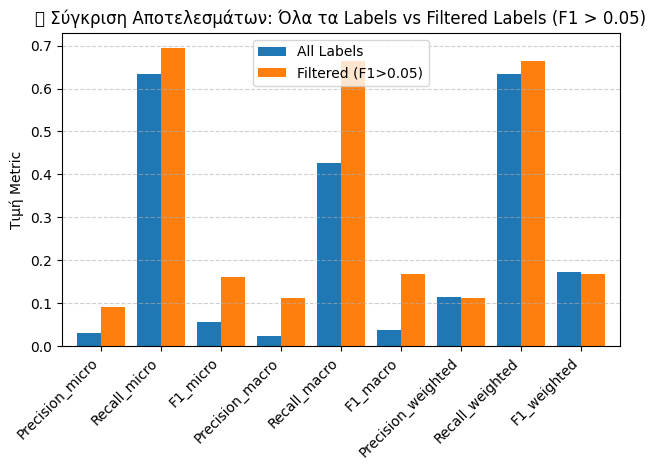

In [56]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# --- 1. Φόρτωση αρχικών συνολικών metrics ---
overall_path = "/Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/overall_metrics.json"
with open(overall_path, "r") as f:
    overall = json.load(f)

# --- 2. Φόρτωση per-label metrics & φιλτράρισμα ---
df = pd.read_csv("/Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/per_label_metrics.csv")
filtered = df[df["f1"] > 0.05].copy()

# --- 3. Υπολογισμός νέων συνολικών metrics (filtered labels) ---
tp_total = filtered["tp"].sum()
fp_total = filtered["fp"].sum()
fn_total = filtered["fn"].sum()

micro_precision = tp_total / (tp_total + fp_total)
micro_recall = tp_total / (tp_total + fn_total)
micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

weights = filtered["n"] / filtered["n"].sum()
weighted_precision = (filtered["precision"] * weights).sum()
weighted_recall = (filtered["recall"] * weights).sum()
weighted_f1 = (filtered["f1"] * weights).sum()

macro_precision = filtered["precision"].mean()
macro_recall = filtered["recall"].mean()
macro_f1 = filtered["f1"].mean()

# --- 4. Δημιουργία συγκριτικού πίνακα ---
comparison = pd.DataFrame({
    "Metric": ["Precision_micro", "Recall_micro", "F1_micro",
               "Precision_macro", "Recall_macro", "F1_macro",
               "Precision_weighted", "Recall_weighted", "F1_weighted"],
    "All_Labels": [overall["precision_micro"], overall["recall_micro"], overall["f1_micro"],
                   overall["precision_macro"], overall["recall_macro"], overall["f1_macro"],
                   overall["precision_weighted"], overall["recall_weighted"], overall["f1_weighted"]],
    "Filtered_Labels": [micro_precision, micro_recall, micro_f1,
                        macro_precision, macro_recall, macro_f1,
                        weighted_precision, weighted_recall, weighted_f1]
})

comparison.set_index("Metric", inplace=True)
comparison = comparison.round(3)
display(comparison)

# --- 5. Οπτικοποίηση ---
plt.figure(figsize=(10, 6))
comparison.plot(kind="bar", width=0.8)
plt.title("📊 Σύγκριση Αποτελεσμάτων: Όλα τα Labels vs Filtered Labels (F1 > 0.05)")
plt.ylabel("Τιμή Metric")
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(["All Labels", "Filtered (F1>0.05)"])
plt.tight_layout()
plt.show()


— Χειρότερα 20 labels κατά F1 —


,label,prevalence,precision,recall,f1,tp,fp,fn,n,auc
0,installer,0.000018,0.0,0.0,0.0,0,0,4,223300,0.500000
1,fakejquery,0.000000,0.0,0.0,0.0,0,0,0,223300,NaN
2,ftp,0.000000,0.0,0.0,0.0,0,176791,0,223300,NaN
3,gamethief,0.000063,0.0,0.0,0.0,0,10652,14,223300,0.475910
4,hidelink,0.000000,0.0,0.0,0.0,0,0,0,223300,NaN
5,nettool,0.000090,0.0,0.0,0.0,0,35336,20,223300,0.420857
6,nuker,0.000004,0.0,0.0,0.0,0,69753,1,223300,0.342942
7,phishing,0.000000,0.0,0.0,0.0,0,0,0,223300,NaN
8,porn,0.000255,0.0,0.0,0.0,0,5979,57,223300,0.486600
9,pua,0.043292,0.0,0.0,0.0,0,924,9667,223300,0.497788


— Καλύτερα 20 labels κατά F1 —


,label,prevalence,precision,recall,f1,tp,fp,fn,n,auc
74,adware,0.097568,0.255391,0.597420,0.357818,13016,37949,8771,223300,0.706002
73,autorun,0.091532,0.207728,0.551054,0.301718,11263,42957,9176,223300,0.671023
72,backdoor,0.089248,0.233003,0.418235,0.299276,8335,27437,11594,223300,0.642515
71,worm,0.134339,0.134354,1.000000,0.236883,29998,193277,0,223300,0.500065
70,injector,0.107550,0.108036,0.990881,0.194829,23797,196473,219,223300,0.502493
69,spyware,0.103833,0.104368,0.995428,0.188927,23080,198061,106,223300,0.502847
68,banker,0.099082,0.098416,0.968814,0.178682,21435,196364,690,223300,0.496380
67,passwordstealer,0.105607,0.163787,0.168052,0.165892,3963,20233,19619,223300,0.533374
66,packed,0.058356,0.112693,0.294068,0.162942,3832,30172,9199,223300,0.575653
65,ransom,0.068074,0.071395,0.940662,0.132717,14299,185981,902,223300,0.523454


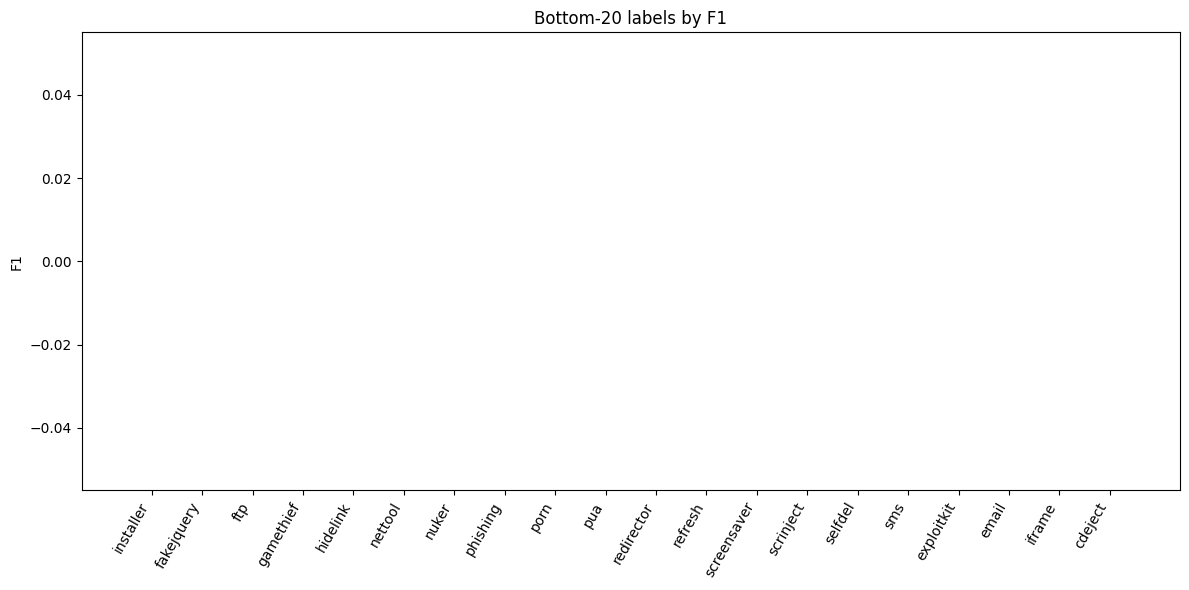

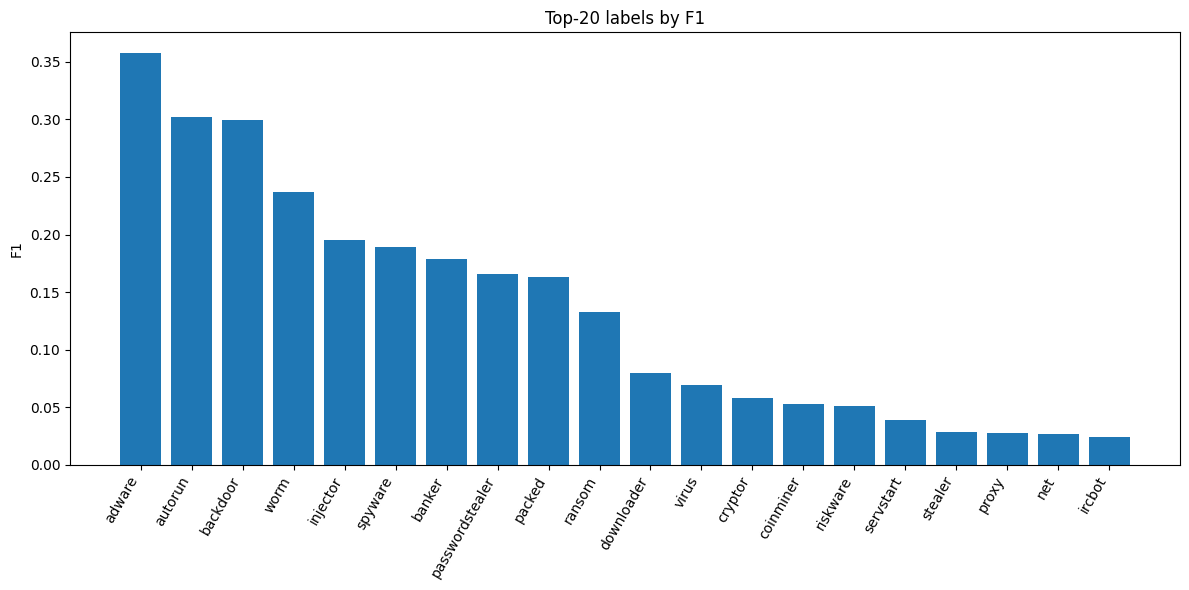

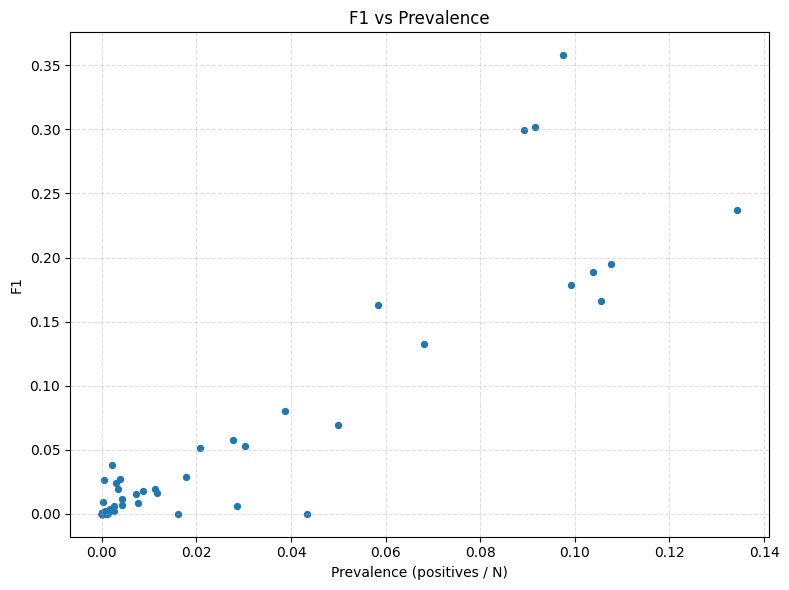

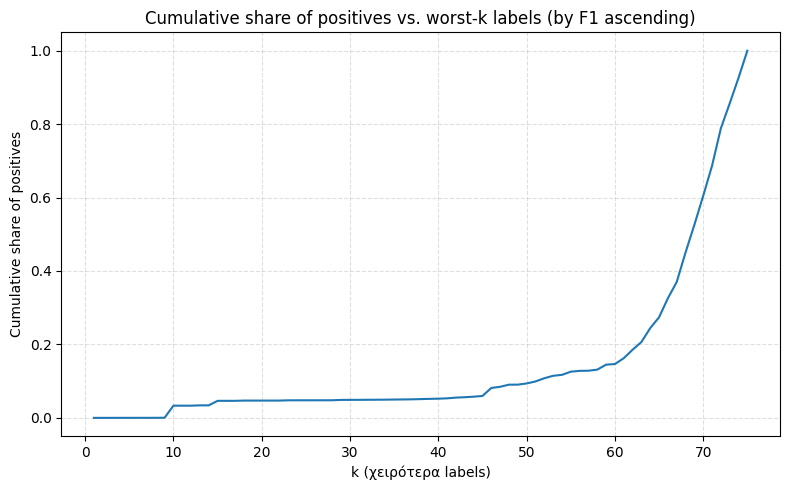

— Red-flag labels για έλεγχο (π.χ. κακό split/πολύ σπάνιες κλάσεις) —


,label,prevalence,precision,recall,f1,tp,fp,fn,n,auc
0,installer,0.000018,0.000000,0.000000,0.000000,0,0,4,223300,0.500000
1,fakejquery,0.000000,0.000000,0.000000,0.000000,0,0,0,223300,NaN
2,ftp,0.000000,0.000000,0.000000,0.000000,0,176791,0,223300,NaN
3,gamethief,0.000063,0.000000,0.000000,0.000000,0,10652,14,223300,0.475910
4,hidelink,0.000000,0.000000,0.000000,0.000000,0,0,0,223300,NaN
5,nettool,0.000090,0.000000,0.000000,0.000000,0,35336,20,223300,0.420857
6,nuker,0.000004,0.000000,0.000000,0.000000,0,69753,1,223300,0.342942
7,phishing,0.000000,0.000000,0.000000,0.000000,0,0,0,223300,NaN
8,porn,0.000255,0.000000,0.000000,0.000000,0,5979,57,223300,0.486600
9,pua,0.043292,0.000000,0.000000,0.000000,0,924,9667,223300,0.497788


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV = "/Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/per_label_metrics.csv"
df = pd.read_csv(CSV)

# Βασικός πίνακας ταξινομημένος κατά F1 (αυξανόμενα)
cols = ["label", "prevalence", "precision", "recall", "f1", "tp", "fp", "fn", "n", "auc"]
df_sorted = df[cols].sort_values("f1", ascending=True).reset_index(drop=True)

print("— Χειρότερα 20 labels κατά F1 —")
display(df_sorted.head(20))

print("— Καλύτερα 20 labels κατά F1 —")
display(df_sorted.tail(20).iloc[::-1])

# ==== Plot 1: Bottom-20 labels by F1 ====
bottom = df_sorted.head(20).copy()
plt.figure(figsize=(12, 6))
plt.bar(bottom["label"], bottom["f1"])
plt.title("Bottom-20 labels by F1")
plt.ylabel("F1")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

# ==== Plot 2: Top-20 labels by F1 ====
top = df_sorted.tail(20).iloc[::-1].copy()
plt.figure(figsize=(12, 6))
plt.bar(top["label"], top["f1"])
plt.title("Top-20 labels by F1")
plt.ylabel("F1")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

# ==== Plot 3: F1 vs Prevalence (scatter) ====
plt.figure(figsize=(8, 6))
plt.scatter(df["prevalence"], df["f1"], s=18)
plt.title("F1 vs Prevalence")
plt.xlabel("Prevalence (positives / N)")
plt.ylabel("F1")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# ==== Plot 4: Cumulative share των samples που ανήκουν στα χειρότερα labels ====
# Ταξινόμηση κατά F1 (αυξανόμενα) και cumulative άθροιση των samples (n * prevalence ≈ positives)
d = df_sorted.copy()
d["positives"] = (d["prevalence"] * d["n"]).astype(int)
d["cum_pos"] = d["positives"].cumsum()
d["cum_pos_share"] = d["cum_pos"] / d["positives"].sum()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(d)+1), d["cum_pos_share"])
plt.title("Cumulative share of positives vs. worst-k labels (by F1 ascending)")
plt.xlabel("k (χειρότερα labels)")
plt.ylabel("Cumulative share of positives")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# ==== Bonus: Πίνακας "κόκκινης λίστας" για debugging ====
# Labels με πολύ χαμηλό F1 ή AUC NaN ή warnings τύπου "Only one class in y_true"
red_flags = df_sorted[
    (df_sorted["f1"] <= 0.02) |
    (df_sorted["auc"].isna()) |
    (df_sorted["recall"] == 0) |
    (df_sorted["precision"] == 0)
][cols].head(40)

print("— Red-flag labels για έλεγχο (π.χ. κακό split/πολύ σπάνιες κλάσεις) —")
display(red_flags)


**PART 2 - For better metrics**

In [28]:
# --- Cell 1: imports, paths, constants & basic helpers ---

from pathlib import Path
import json, gc, math
import numpy as np
import scipy.sparse as sp
import lightgbm as lgb

from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score
)

# Paths (όπως τα έχεις τώρα)
BASE = Path.home() / "Desktop" / "Malware Project"
VEC  = BASE / "data" / "behavior_vectors_paper"   # εδώ είναι τα X/Y parts + models/
MODELS_DIR = VEC / "models"

# αρχεία εισόδου/εξόδου
LABEL_MAP = VEC / "label_map.json"           # από το προηγούμενο βήμα
THR_JSON  = VEC / "best_thresholds.json"     # θα το γράψουμε εδώ
CSV_PER_LABEL = VEC / "per_label_metrics_thr.csv"
OVERALL_JSON  = VEC / "overall_metrics_thr.json"

# ποιο split να χρησιμοποιήσουμε για validation (sub-split μέσα στο test)
# έχεις συνολικά 45 test parts -> θα χρησιμοποιήσουμε τα 10 πρώτα για validation
VAL_PARTS = 10   # μπορείς να το αλλάξεις π.χ. 15
K_CHUNK = 1      # διαβάζουμε 1 part κάθε φορά (κρατάμε χαμηλά RAM)

# --- διαβάζουμε labels ---
with open(LABEL_MAP, "r") as f:
    label_names = json.load(f)["labels"]
n_labels = len(label_names)

# --- helpers για paths parts ---
def part_paths(i: int, split: str = "test"):
    xp = VEC / f"{split}_part{i:03d}.npz"
    yp = VEC / f"y_{split}_part{i:03d}.npy"
    return xp, yp

def load_part(i: int, split: str = "test"):
    xp, yp = part_paths(i, split)
    X = sp.load_npz(xp)                     # csr
    Y = np.load(yp, allow_pickle=False)     # (rows, n_labels) int8
    return X, Y

def iter_parts(start: int, end: int, split: str = "test"):
    """streaming loader για parts [start, end)"""
    for i in range(start, end):
        yield load_part(i, split)

# --- helper: φόρτωση booster για συγκεκριμένο label ---
def load_booster_for(label_idx: int) -> lgb.Booster:
    model_path = MODELS_DIR / f"lgb_label_{label_idx:03d}.txt"
    return lgb.Booster(model_file=str(model_path))


In [29]:
# --- Cell 2: predict_proba σε validation και final test (streaming) ---

def predict_proba_stream(label_idx: int, start_part: int, end_part: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Επιστρέφει (y_true, y_proba) για parts [start_part, end_part) για ΕΝΑ label.
    Streaming για χαμηλή μνήμη.
    """
    booster = load_booster_for(label_idx)
    y_true_all = []
    y_proba_all = []

    for X, Y in iter_parts(start_part, end_part, split="test"):
        y_true = Y[:, label_idx].astype(np.int32)   # (rows,)
        y_proba = booster.predict(X).astype(np.float32)  # (rows,)
        y_true_all.append(y_true)
        y_proba_all.append(y_proba)
        del X, Y
        gc.collect()

    y_true_all  = np.concatenate(y_true_all)
    y_proba_all = np.concatenate(y_proba_all)
    return y_true_all, y_proba_all

def predict_all_labels_stream(start_part: int, end_part: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Επιστρέφει (Y_true, Y_proba) για ΟΛΑ τα labels πάνω στα parts [start_part, end_part).
    Y_true  : (N, n_labels) int
    Y_proba : (N, n_labels) float
    """
    # Παίρνουμε το shape από ένα part
    X0, Y0 = load_part(start_part, split="test")
    rows_total_est = 0
    for i in range(start_part, end_part):
        xp, yp = part_paths(i, "test")
        rows_total_est += int(np.load(yp, mmap_mode="r").shape[0])

    Y_true_cols  = [np.empty((0,), dtype=np.int32) for _ in range(n_labels)]
    Y_proba_cols = [np.empty((0,), dtype=np.float32) for _ in range(n_labels)]
    del X0, Y0

    for li in range(n_labels):
        y_t, y_p = predict_proba_stream(li, start_part, end_part)
        Y_true_cols[li]  = y_t
        Y_proba_cols[li] = y_p

    # stack by columns
    Y_true  = np.column_stack(Y_true_cols)          # (N, n_labels)
    Y_proba = np.column_stack(Y_proba_cols).astype(np.float32)
    return Y_true, Y_proba


In [30]:
# --- Cell 3: εύρεση βέλτιστου threshold για κάθε label πάνω στο validation split ---

def best_threshold_for_label(y_true: np.ndarray, y_proba: np.ndarray) -> float:
    """
    Σαρώνουμε thresholds και διαλέγουμε αυτό με max F1.
    Απλό grid 0.05 βήμα (20 τιμές) για ταχύτητα — μπορείς να το πυκνώσεις αν θες.
    """
    if y_true.sum() == 0:
        # δεν έχει θετικά στο validation -> κράτα 0.5
        return 0.5

    best_thr, best_f1 = 0.5, -1.0
    for thr in np.linspace(0.05, 0.95, 19, dtype=np.float32):
        y_pred = (y_proba >= thr).astype(np.int32)
        _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, float(thr)
    return best_thr

# --- Validation subset από τα test parts ---
VAL_START, VAL_END = 0, VAL_PARTS          # π.χ. [0..10)
TEST_START, TEST_END = VAL_END, 45         # υπόλοιπα 35 parts για τελικό test

print(f"Validation parts: [{VAL_START}, {VAL_END})  | Final test parts: [{TEST_START}, {TEST_END})")

# Μαζεύουμε validation προβλέψεις για ΟΛΑ τα labels
Yv_true, Yv_proba = predict_all_labels_stream(VAL_START, VAL_END)

# Υπολογίζουμε thresholds
best_thr = []
for li in range(n_labels):
    t = best_threshold_for_label(Yv_true[:, li], Yv_proba[:, li])
    best_thr.append(t)

# Σώζουμε thresholds
with open(THR_JSON, "w") as f:
    json.dump({"thresholds": best_thr, "labels": label_names}, f, indent=2)

print("Saved thresholds ->", THR_JSON)


Validation parts: [0, 10)  | Final test parts: [10, 45)
Saved thresholds -> /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/best_thresholds.json


In [31]:
# --- Cell 4: τελικό evaluation στα υπόλοιπα test parts με τα thresholds ---

# Προβλέψεις στο final test split
Yt_true, Yt_proba = predict_all_labels_stream(TEST_START, TEST_END)

# Εφαρμογή thresholds
with open(THR_JSON, "r") as f:
    best_thr = json.load(f)["thresholds"]

Yt_pred = (Yt_proba >= np.array(best_thr, dtype=np.float32)).astype(np.int32)

# --- per-label metrics & CSV ---
import pandas as pd

rows = []
for li, name in enumerate(label_names):
    y_true = Yt_true[:, li]
    y_pred = Yt_pred[:, li]
    y_prob = Yt_proba[:, li]

    # prevalence
    prev = float(y_true.mean())

    # ROC-AUC per label (handle single-class)
    try:
        auc = float(roc_auc_score(y_true, y_prob))
    except Exception:
        auc = float("nan")

    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())
    n  = int(y_true.shape[0])

    rows.append({
        "label_idx": li,
        "label": name,
        "threshold": float(best_thr[li]),
        "prevalence": prev,
        "auc": auc,
        "precision": float(p),
        "recall": float(r),
        "f1": float(f1),
        "tp": tp, "fp": fp, "fn": fn, "n": n
    })

df = pd.DataFrame(rows)
df.to_csv(CSV_PER_LABEL, index=False)
print("Saved per-label CSV ->", CSV_PER_LABEL)

# --- overall metrics (micro/macro/weighted + accuracy_like) ---
overall = {}

# micro/macro/weighted για Precision/Recall/F1
for avg in ["micro", "macro", "weighted"]:
    p, r, f1, _ = precision_recall_fscore_support(Yt_true, Yt_pred, average=avg, zero_division=0)
    overall[f"precision_{avg}"] = float(p)
    overall[f"recall_{avg}"]    = float(r)
    overall[f"f1_{avg}"]        = float(f1)

# ROC-AUC micro (ravel), macro (per-label mean)
try:
    overall["roc_auc_micro"] = float(roc_auc_score(Yt_true.ravel(), Yt_proba.ravel()))
except Exception:
    overall["roc_auc_micro"] = float("nan")

per_label_auc = []
for li in range(n_labels):
    yt = Yt_true[:, li]
    yp = Yt_proba[:, li]
    try:
        per_label_auc.append(roc_auc_score(yt, yp))
    except Exception:
        pass
overall["roc_auc_macro"] = float(np.nanmean(per_label_auc)) if per_label_auc else float("nan")

# per-sample recall ("accuracy_like")
yt_bool = Yt_true.astype(bool)
yp_bool = Yt_pred.astype(bool)
tp_per_sample = np.logical_and(yt_bool, yp_bool).sum(axis=1).astype(np.float32)
pos_per_sample = yt_bool.sum(axis=1).astype(np.float32)
pos_per_sample[pos_per_sample == 0] = np.nan
sample_recalls = tp_per_sample / pos_per_sample
overall["accuracy_like"] = float(np.nanmean(sample_recalls))

# αποθήκευση
with open(OVERALL_JSON, "w") as f:
    json.dump(overall, f, indent=2)

print("Saved OVERALL metrics ->", OVERALL_JSON)
overall


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/pyth

Saved per-label CSV -> /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/per_label_metrics_thr.csv


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/pyth

Saved OVERALL metrics -> /Users/georgektenas/Desktop/Malware Project/data/behavior_vectors_paper/overall_metrics_thr.json


/opt/homebrew/Caskroom/miniforge/base/envs/training/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


{'precision_micro': 0.029799344390932254,
 'recall_micro': 0.6576427038236257,
 'f1_micro': 0.05701519558869797,
 'precision_macro': 0.02280372091293912,
 'recall_macro': 0.4043248832180551,
 'f1_macro': 0.03548061950674845,
 'precision_weighted': 0.11848064328746091,
 'recall_weighted': 0.6576427038236257,
 'f1_weighted': 0.1808641041679146,
 'roc_auc_micro': 0.6196183326087448,
 'roc_auc_macro': 0.5328018196430948,
 'accuracy_like': 0.6603561639785767}